# download packages

In [1]:
import warnings # this shit needs to stfu
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [2]:
%pip install plotly

Note: you may need to restart the kernel to use updated packages.


# Import the libraries

In [3]:
import numpy as np
import pandas as pd

import io
import os
import tensorflow as tf

from PIL import Image
from glob import glob
import itertools

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, Dropout, Dense, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import keras


from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

2025-05-06 14:23:11.222727: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746541391.397651      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746541391.458720      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# prepare train test splits

In [4]:
def prepare_for_train_test(X, Y):
    # Split dataset (70% training, 30% testing)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

    # Normalize images (convert pixel values from 0-255 to 0-1)
    X_train = X_train.astype(np.float16) / 255.0
    X_test = X_test.astype(np.float32) / 255.0

    return X_train, X_test, Y_train, Y_test


# Prepare model

In [5]:
learning_rate = float(input("Enter the learning rate: "))
dropout_rate = float(input("Enter the Dropout rate: "))
batch_size = int(input("Enter the batch size: "))
epochs = int(input("Enter the number of epochs: "))

Enter the learning rate:  0.001
Enter the Dropout rate:  0.2
Enter the batch size:  32
Enter the number of epochs:  30


In [6]:
def create_model(learning_rate):
    model = Sequential()

    model.add(Conv2D(16, kernel_size=(3,3), input_shape=(28, 28, 3), activation = 'relu', padding='same'))
    #model.add(BatchNormalization())
    #model.add(tf.keras.layers.Activation('relu'))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Conv2D(32, kernel_size=(3,3), padding='same'))
    #model.add(BatchNormalization())
    #model.add(tf.keras.layers.Activation('relu'))
    model.add(MaxPool2D(pool_size=(2,2), padding='same'))

    model.add(Conv2D(64, kernel_size=(3,3), padding='same'))
    #model.add(BatchNormalization())
    #model.add(tf.keras.layers.Activation('relu'))
    model.add(MaxPool2D(pool_size=(2,2), padding='same'))

    model.add(Conv2D(128, kernel_size=(3,3), padding='same'))
    #model.add(BatchNormalization())
    #model.add(tf.keras.layers.Activation('relu'))
    model.add(MaxPool2D(pool_size=(2,2), padding='same'))

    model.add(Conv2D(256, kernel_size=(3,3), padding='same'))
    #model.add(BatchNormalization())
    #model.add(tf.keras.layers.Activation('relu'))
    model.add(MaxPool2D(pool_size=(2,2), padding='same'))

    #model.add(Dropout(0.3))  # Dropout after last Conv block
    model.add(Flatten())

    model.add(Dense(64, activation='relu'))
    #model.add(Dropout(dropout_rate))  # Dropout after first dense

    model.add(Dense(32, activation='relu'))
    #model.add(Dropout(0.3))  # Optional: can remove if already stable

    model.add(Dense(7, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    print(model.summary())
    return model


# prepare the training plan

In [7]:
def train_model(model, X_train, Y_train, EPOCHS=epochs):
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto')
    
    history = model.fit(X_train,
                        Y_train,
                        validation_split=0.2,
                        batch_size = batch_size,
                        epochs = EPOCHS,
                        callbacks = [reduce_lr, early_stop])
    return history

# test the model

In [8]:
def test_model(model, X_test, Y_test):
    model_acc = model.evaluate(X_test, Y_test, verbose=0)[1]
    print("Test Accuracy: {:.3f}%".format(model_acc * 100))
    
    y_true = np.array(Y_test).flatten()  # Ensure y_true is 1D
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)  # Convert to class indices
    
    clr = classification_report(y_true, y_pred, target_names=label_mapping.values())
    print(clr)
    
    sample_data = X_test[:15]
    plt.figure(figsize=(22, 12))
    
    for i in range(len(sample_data)):
        plt.subplot(3, 5, i + 1)
        plt.imshow(sample_data[i])  # Add cmap='gray' if images are grayscale
        plt.title(f"{label_mapping[y_true[i]]} | {label_mapping[y_pred[i]]}")
        plt.axis("off")
    
    plt.show()


# training curves plot

In [9]:
def plot_model_training_curve(history):
    fig = make_subplots(rows=1, cols=2, subplot_titles=['Model Accuracy', 'Model Loss'])
    fig.add_trace(
        go.Scatter(
            y=history.history['accuracy'], 
            name='train_acc'), 
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_accuracy'], 
            name='val_acc'), 
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['loss'], 
            name='train_loss'), 
        row=1, col=2)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_loss'], 
            name='val_loss'), 
        row=1, col=2)
    fig.show()

# multi class confusion matrix

In [10]:
def create_confusion_matrix(model, x_test_normalized, y_test, cm_plot_labels, name):
    y_predict_classes, y_true_classes = cal_true_pred_classes(model, x_test_normalized, y_test)

    confusion_matrix_computed = confusion_matrix(y_true_classes, y_predict_classes)

    plot_confusion_matrix(confusion_matrix_computed, cm_plot_labels, name) 

In [11]:
def plot_confusion_matrix(cm, classes,
                          name,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(name)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
#     b, t = plt.ylim()
#     b += 0.5
#     t -= 0.5
#     plt.ylim(b, t)
    
    plt.tight_layout()
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    fig = plt
    fig.savefig('C:/stse/sem8/SDP/' + name + '_confusion_matrix.png', dpi=300)

# read the data

In [12]:
image_dir = "/kaggle/input/ham10000-preprocessed-dataset/balanced_and_standardized_images/balanced_and_standardized_images"

# Get all image paths
all_image_paths = os.listdir(image_dir)

# Create dict: key = image filename, value = full path
imageid_path_dict = {img_name: os.path.join(image_dir, img_name) for img_name in all_image_paths}

lesion_type_dict = {
    'nv': 'Melanocytic nevi (nv)',
    'mel': 'Melanoma (mel)',
    'bkl': 'Benign keratosis-like lesions (bkl)',
    'bcc': 'Basal cell carcinoma (bcc)',
    'akiec': 'Actinic keratoses (akiec)',
    'vasc': 'Vascular lesions (vasc)',
    'df': 'Dermatofibroma (df)'
}
label_mapping = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}
reverse_label_mapping = dict((value, key) for key, value in label_mapping.items())

In [13]:
data = pd.read_csv("/kaggle/input/ham10000-preprocessed-dataset/balanced and standardized images meta for custom.csv")

# Creating New Columns for better readability

# data['path'] = data['image_id'].map(imageid_path_dict.get)
# data['cell_type'] = data['dx'].map(lesion_type_dict.get) 
# data['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes


In [14]:
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0001751,ISIC_0024698.jpg,nv,consensus,70.0,male,face
1,HAM_0000559,ISIC_0024693.jpg,nv,follow_up,45.0,female,upper extremity
2,HAM_0004932,ISIC_0032212.jpg,nv,follow_up,45.0,female,foot
3,HAM_0004516,ISIC_0025775.jpg,nv,follow_up,45.0,female,neck
4,HAM_0006510,ISIC_0029828.jpg,nv,follow_up,55.0,female,lower extremity


In [15]:
data.describe(exclude=[np.number])

,lesion_id,image_id,dx,dx_type,sex,localization
count,46935,46935,46935,46935,46935,46935
unique,7470,46935,7,4,3,15
top,HAM_0006946,ISIC_0029297_aug35.jpg,nv,histo,male,lower extremity
freq,192,1,6705,34436,27137,11938


In [16]:
data.isnull().any().sum()

1

In [17]:
data.isnull().sum()


lesion_id        0
image_id         0
dx               0
dx_type          0
age             69
sex              0
localization     0
dtype: int64

# Imputing the Null values and preparing the data

In [18]:
# Handling null values
data['age'].fillna(value=int(data['age'].mean()), inplace=True)
# Converting dtype of age to int32
data['age'] = data['age'].astype('int32')

In [19]:
data.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

In [20]:
# Adding cell_type and image_path columns
data['cell_type'] = data['dx'].map(lesion_type_dict.get)
data['path'] = data['image_id'].map(imageid_path_dict.get)

In [21]:
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path
0,HAM_0001751,ISIC_0024698.jpg,nv,consensus,70,male,face,Melanocytic nevi (nv),/kaggle/input/ham10000-preprocessed-dataset/ba...
1,HAM_0000559,ISIC_0024693.jpg,nv,follow_up,45,female,upper extremity,Melanocytic nevi (nv),/kaggle/input/ham10000-preprocessed-dataset/ba...
2,HAM_0004932,ISIC_0032212.jpg,nv,follow_up,45,female,foot,Melanocytic nevi (nv),/kaggle/input/ham10000-preprocessed-dataset/ba...
3,HAM_0004516,ISIC_0025775.jpg,nv,follow_up,45,female,neck,Melanocytic nevi (nv),/kaggle/input/ham10000-preprocessed-dataset/ba...
4,HAM_0006510,ISIC_0029828.jpg,nv,follow_up,55,female,lower extremity,Melanocytic nevi (nv),/kaggle/input/ham10000-preprocessed-dataset/ba...


In [22]:
# Adding image pixels
data['image_pixel'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((28,28))))

In [23]:
data.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,image_pixel
0,HAM_0001751,ISIC_0024698.jpg,nv,consensus,70,male,face,Melanocytic nevi (nv),/kaggle/input/ham10000-preprocessed-dataset/ba...,"[[[158, 130, 154], [170, 143, 171], [175, 149,..."
1,HAM_0000559,ISIC_0024693.jpg,nv,follow_up,45,female,upper extremity,Melanocytic nevi (nv),/kaggle/input/ham10000-preprocessed-dataset/ba...,"[[[235, 150, 169], [228, 137, 160], [217, 125,..."
2,HAM_0004932,ISIC_0032212.jpg,nv,follow_up,45,female,foot,Melanocytic nevi (nv),/kaggle/input/ham10000-preprocessed-dataset/ba...,"[[[229, 152, 151], [234, 155, 155], [235, 152,..."
3,HAM_0004516,ISIC_0025775.jpg,nv,follow_up,45,female,neck,Melanocytic nevi (nv),/kaggle/input/ham10000-preprocessed-dataset/ba...,"[[[205, 121, 115], [214, 127, 125], [220, 131,..."
4,HAM_0006510,ISIC_0029828.jpg,nv,follow_up,55,female,lower extremity,Melanocytic nevi (nv),/kaggle/input/ham10000-preprocessed-dataset/ba...,"[[[209, 151, 165], [211, 154, 169], [212, 158,..."


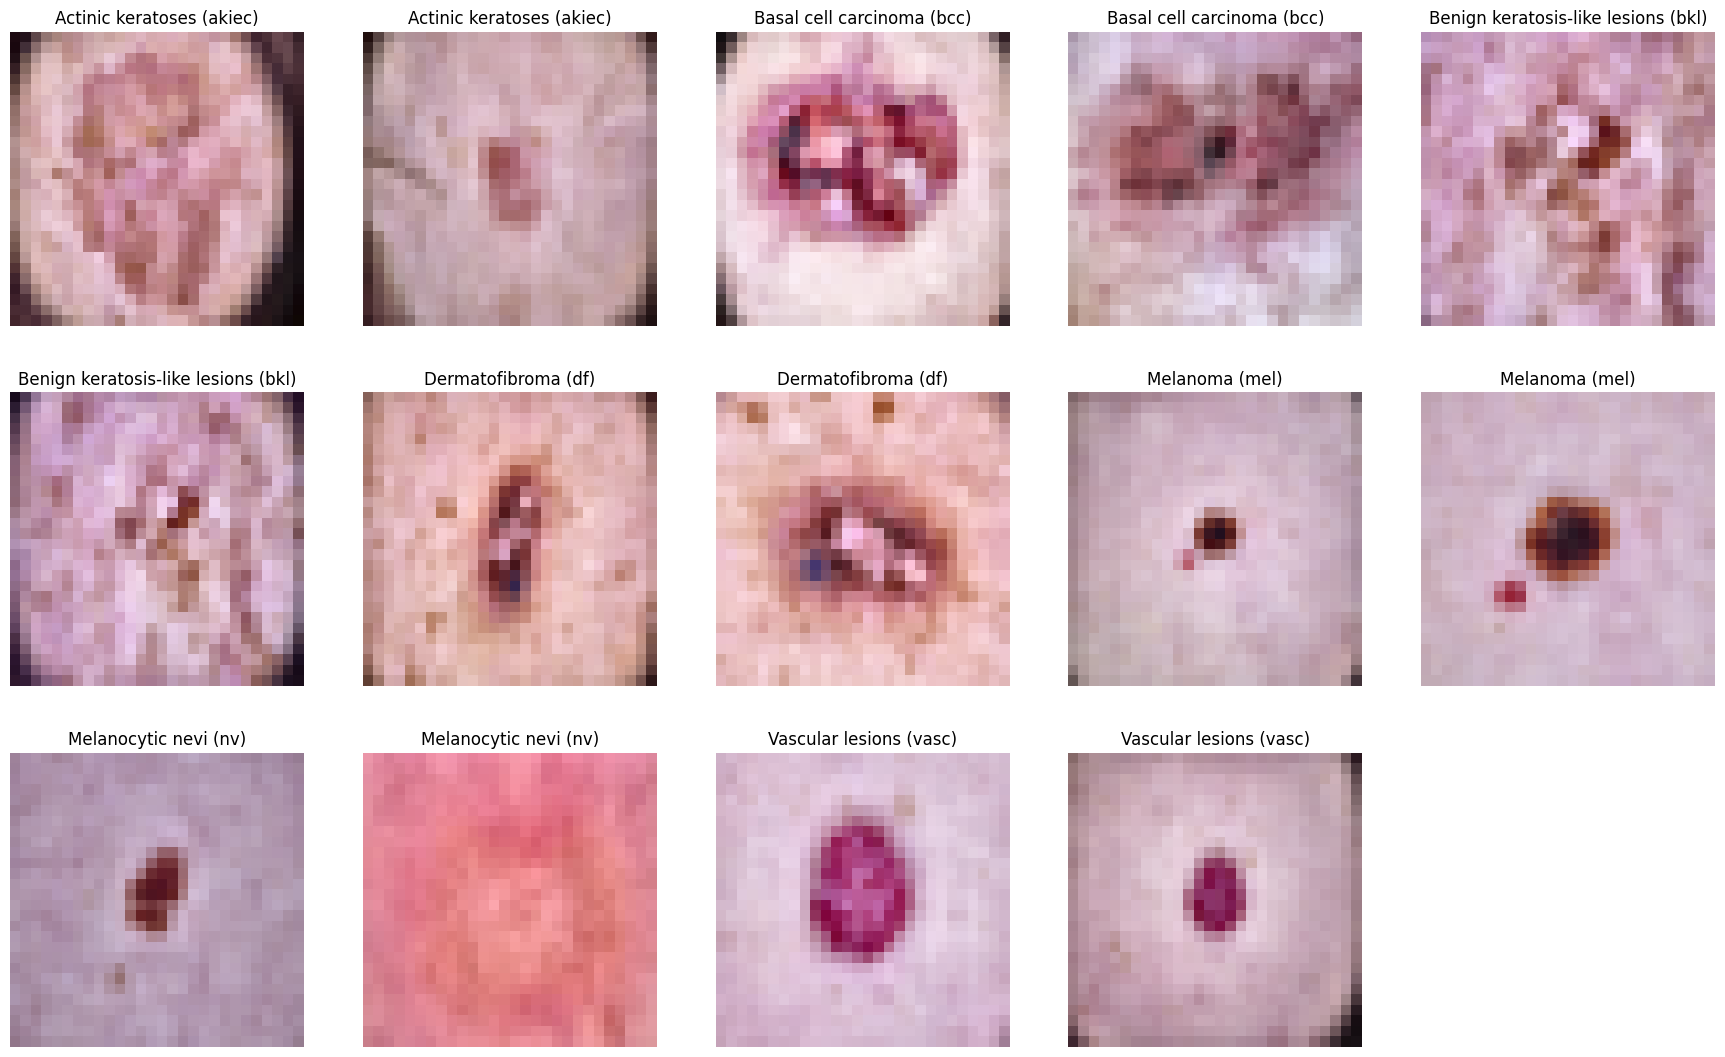

In [24]:
# Displaying 2 images for each label
sample_data = data.groupby('dx').apply(lambda df: df.iloc[:2, [9, 7]])
plt.figure(figsize=(22, 32))
for i in range(14):
    plt.subplot(7, 5, i + 1)
    plt.imshow(np.squeeze(sample_data['image_pixel'][i]))
    img_label = sample_data['cell_type'][i]
    plt.title(img_label)
    plt.axis("off")
plt.show();

In [25]:
data['label'] = data['dx'].map(reverse_label_mapping.get)

data = data.sort_values('label')
data = data.reset_index()

In [26]:
counter = 0
frames = [data]
for i in [4, 4, 11, 17, 45, 52]:
    counter += 1
    index = data[data['label'] == counter].index.values
    if len(index) == 0:
        continue  # Skip if no matching index is found
    df_index = data.iloc[int(min(index)):int(max(index) + 1)]
    
    # Replace .append() with pd.concat()
    df_index = pd.concat([df_index] * (i + 1), ignore_index=True)
    
    frames.append(df_index)

In [27]:
len(frames)

7

In [28]:
final_data = pd.concat(frames)

In [29]:
print(data.shape)
print(final_data.shape)

(46935, 12)
(978930, 12)


In [30]:
# ORIGINAL DATA
# Converting image pixel columnm into required format
X_orig = data['image_pixel'].to_numpy()
X_orig = np.stack(X_orig, axis=0)
Y_orig = np.array(data.iloc[:, -1:])
print(X_orig.shape)
print(Y_orig.shape)

(46935, 28, 28, 3)
(46935, 1)


In [31]:
# AUGMENTED DATA
# Converting image pixel columnm into required format
X_aug = final_data['image_pixel'].to_numpy()
X_aug = np.stack(X_aug, axis=0)
Y_aug = np.array(final_data.iloc[:, -1:])
print(X_aug.shape)
print(Y_aug.shape)

(978930, 28, 28, 3)
(978930, 1)


In [32]:
# For Original Dataset
X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = prepare_for_train_test(X_orig, Y_orig)

In [33]:
model =create_model(learning_rate)

I0000 00:00:1746542056.174378      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 2, 2, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 411,367 (1.57 MB)

 Trainable params: 411,367 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

None


In [34]:
X_train_aug, X_test_aug, Y_train_aug, Y_test_aug = prepare_for_train_test(X_aug, Y_aug)

In [35]:
model2_history = train_model(model, X_train_aug, Y_train_aug, epochs)

Epoch 1/30


I0000 00:00:1746542111.639951     101 service.cc:148] XLA service 0x7fa504004df0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746542111.640523     101 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746542112.012831     101 cuda_dnn.cc:529] Loaded cuDNN version 90300


   60/17132 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - accuracy: 0.3506 - loss: 1.6039  

I0000 00:00:1746542114.277170     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


17132/17132 ━━━━━━━━━━━━━━━━━━━━ 60s 3ms/step - accuracy: 0.8430 - loss: 0.4374 - val_accuracy: 0.9634 - val_loss: 0.1051 - learning_rate: 0.0010
Epoch 2/30
17132/17132 ━━━━━━━━━━━━━━━━━━━━ 49s 3ms/step - accuracy: 0.9685 - loss: 0.0956 - val_accuracy: 0.9653 - val_loss: 0.1102 - learning_rate: 0.0010
Epoch 3/30
17132/17132 ━━━━━━━━━━━━━━━━━━━━ 49s 3ms/step - accuracy: 0.9798 - loss: 0.0637 - val_accuracy: 0.9838 - val_loss: 0.0503 - learning_rate: 0.0010
Epoch 4/30
17132/17132 ━━━━━━━━━━━━━━━━━━━━ 50s 3ms/step - accuracy: 0.9843 - loss: 0.0514 - val_accuracy: 0.9819 - val_loss: 0.0606 - learning_rate: 0.0010
Epoch 5/30
17132/17132 ━━━━━━━━━━━━━━━━━━━━ 50s 3ms/step - accuracy: 0.9867 - loss: 0.0459 - val_accuracy: 0.9846 - val_loss: 0.0558 - learning_rate: 0.0010
Epoch 6/30
17132/17132 ━━━━━━━━━━━━━━━━━━━━ 49s 3ms/step - accuracy: 0.9878 - loss: 0.0434 - val_accuracy: 0.9894 - val_loss: 0.0382 - learning_rate: 0.0010
Epoch 7/30
17132/17132 ━━━━━━━━━━━━━━━━━━━━ 50s 3ms/step - accuracy: 

# save model

In [36]:
# model.save('Skin_Cancer.sav')

# model.save('/kaggle/working/my_model.pb') 

model.save('/kaggle/working/custom model 70-30.keras') 


# save model weights

In [37]:
model.save_weights("/kaggle/working/custom model 70-30 weights.weights.h5")

In [38]:
from IPython.display import FileLink
FileLink("/kaggle/working/model weights.weights.h5")

/kaggle/working/model weights.weights.h5

In [39]:
plot_model_training_curve(model2_history)

Test Accuracy: 98.786%
441/441 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

          nv       1.00      0.92      0.96      2050
         mel       0.96      1.00      0.98      2028
         bkl       0.97      1.00      0.98      1985
         bcc       0.99      1.00      1.00      1967
       akiec       1.00      1.00      1.00      2009
        vasc       1.00      1.00      1.00      1985
          df       1.00      1.00      1.00      2057

    accuracy                           0.99     14081
   macro avg       0.99      0.99      0.99     14081
weighted avg       0.99      0.99      0.99     14081



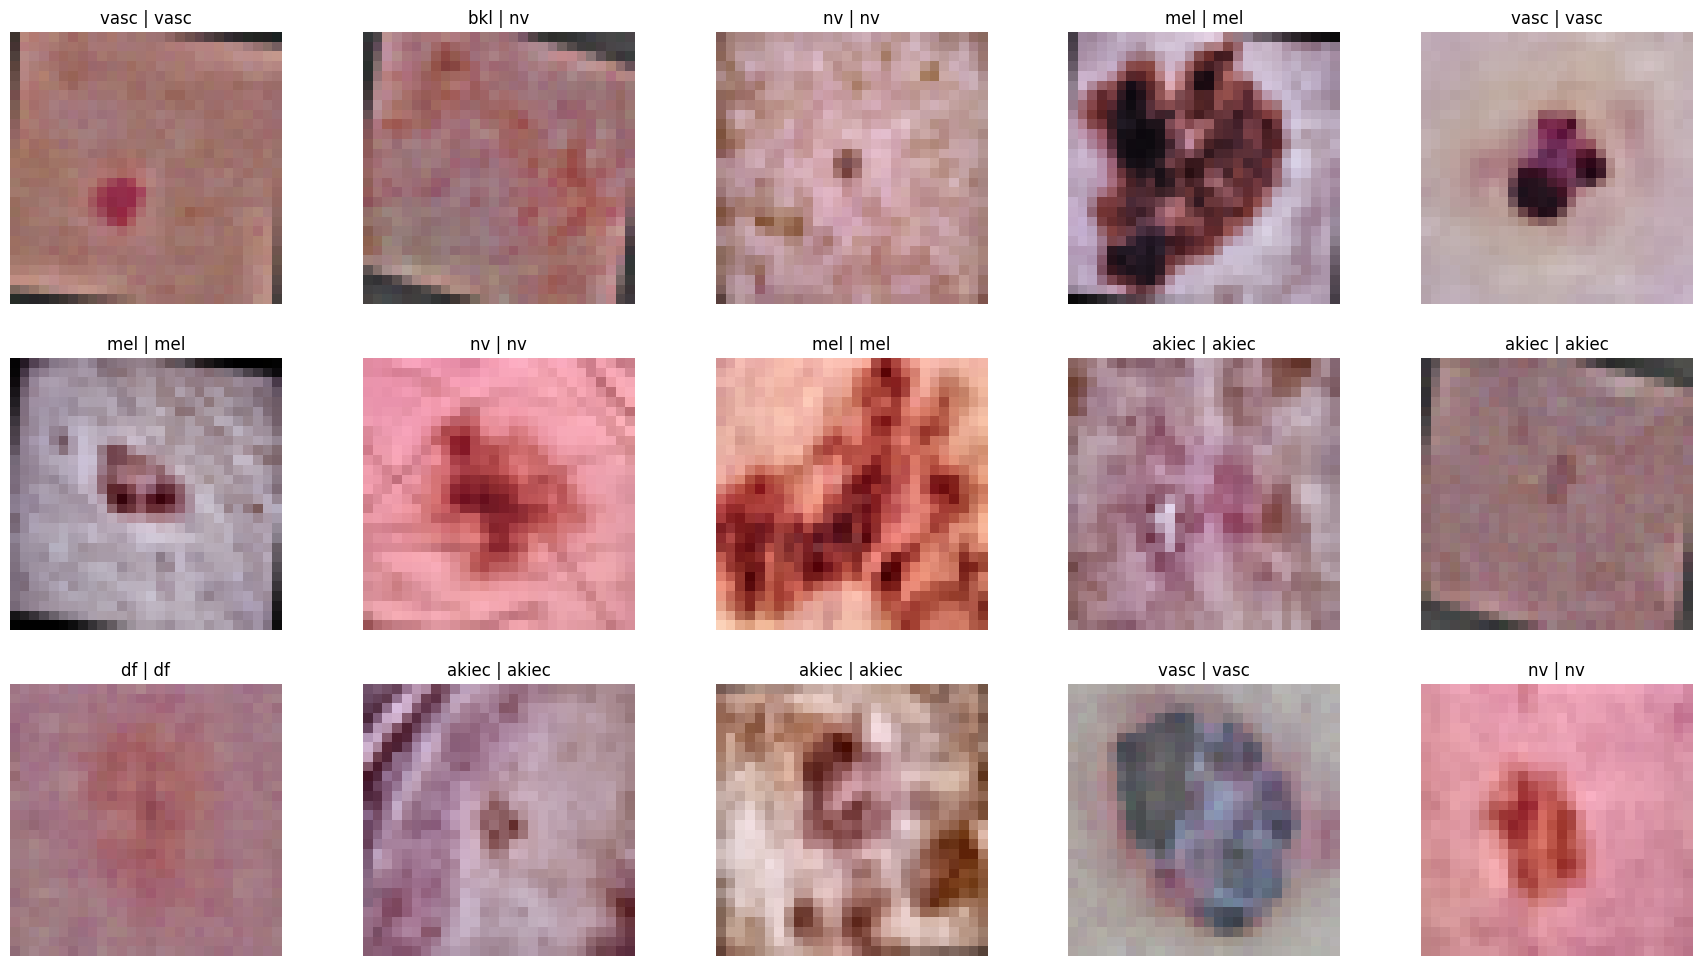

In [40]:
test_model(model, X_test_orig, Y_test_orig)

In [41]:
data.head()
data.iloc[2]

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,image_pixel,label
0,30,HAM_0003093,ISIC_0025218.jpg,nv,follow_up,50,male,trunk,Melanocytic nevi (nv),/kaggle/input/ham10000-preprocessed-dataset/ba...,"[[[224, 122, 146], [234, 133, 158], [245, 150,...",0
1,31,HAM_0005366,ISIC_0026211.jpg,nv,follow_up,50,male,abdomen,Melanocytic nevi (nv),/kaggle/input/ham10000-preprocessed-dataset/ba...,"[[[217, 141, 150], [228, 150, 162], [235, 157,...",0
2,32,HAM_0002108,ISIC_0025457.jpg,nv,follow_up,50,male,abdomen,Melanocytic nevi (nv),/kaggle/input/ham10000-preprocessed-dataset/ba...,"[[[229, 153, 174], [231, 154, 175], [239, 161,...",0
3,33,HAM_0003227,ISIC_0029594.jpg,nv,follow_up,50,male,back,Melanocytic nevi (nv),/kaggle/input/ham10000-preprocessed-dataset/ba...,"[[[227, 154, 172], [238, 163, 182], [240, 164,...",0
4,34,HAM_0000699,ISIC_0031575.jpg,nv,follow_up,50,male,lower extremity,Melanocytic nevi (nv),/kaggle/input/ham10000-preprocessed-dataset/ba...,"[[[231, 153, 166], [232, 153, 165], [232, 150,...",0


index                                                          32
lesion_id                                             HAM_0002108
image_id                                         ISIC_0025457.jpg
dx                                                             nv
dx_type                                                 follow_up
age                                                            50
sex                                                          male
localization                                              abdomen
cell_type                                   Melanocytic nevi (nv)
path            /kaggle/input/ham10000-preprocessed-dataset/ba...
image_pixel     [[[229, 153, 174], [231, 154, 175], [239, 161,...
label                                                           0
Name: 2, dtype: object

In [42]:
one_picture_predict_data = data.iloc[2]
print(one_picture_predict_data)
print(one_picture_predict_data.dx)
#print(one_picture_predict_data.image_pixel)
y_value = reverse_label_mapping.get(one_picture_predict_data.dx)
print(y_value)


one_picture_predict_data.image_pixel.shape
new_one = one_picture_predict_data.image_pixel.reshape((1,28,28,3))
model.predict(new_one)

index                                                          32
lesion_id                                             HAM_0002108
image_id                                         ISIC_0025457.jpg
dx                                                             nv
dx_type                                                 follow_up
age                                                            50
sex                                                          male
localization                                              abdomen
cell_type                                   Melanocytic nevi (nv)
path            /kaggle/input/ham10000-preprocessed-dataset/ba...
image_pixel     [[[229, 153, 174], [231, 154, 175], [239, 161,...
label                                                           0
Name: 2, dtype: object
nv
0


(28, 28, 3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


array([[1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [43]:
print(data.iloc[2].path)
im = np.asarray(Image.open(data.iloc[2].path))
im.shape
im = im.reshape((1,450,600,3))
im.shape
new_one = one_picture_predict_data.image_pixel.reshape((1,28,28,3))
model.predict(new_one)

/kaggle/input/ham10000-preprocessed-dataset/balanced_and_standardized_images/balanced_and_standardized_images/ISIC_0025457.jpg


(450, 600, 3)

(1, 450, 600, 3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


array([[1., 0., 0., 0., 0., 0., 0.]], dtype=float32)